# <p style="background-color:green;font-family:newtimeroman;font-size:200%;color:white;text-align:center;border-radius:20px 20px;"><b>Boosting Methods Capstone Project (Titanic Prediction)</b></p>



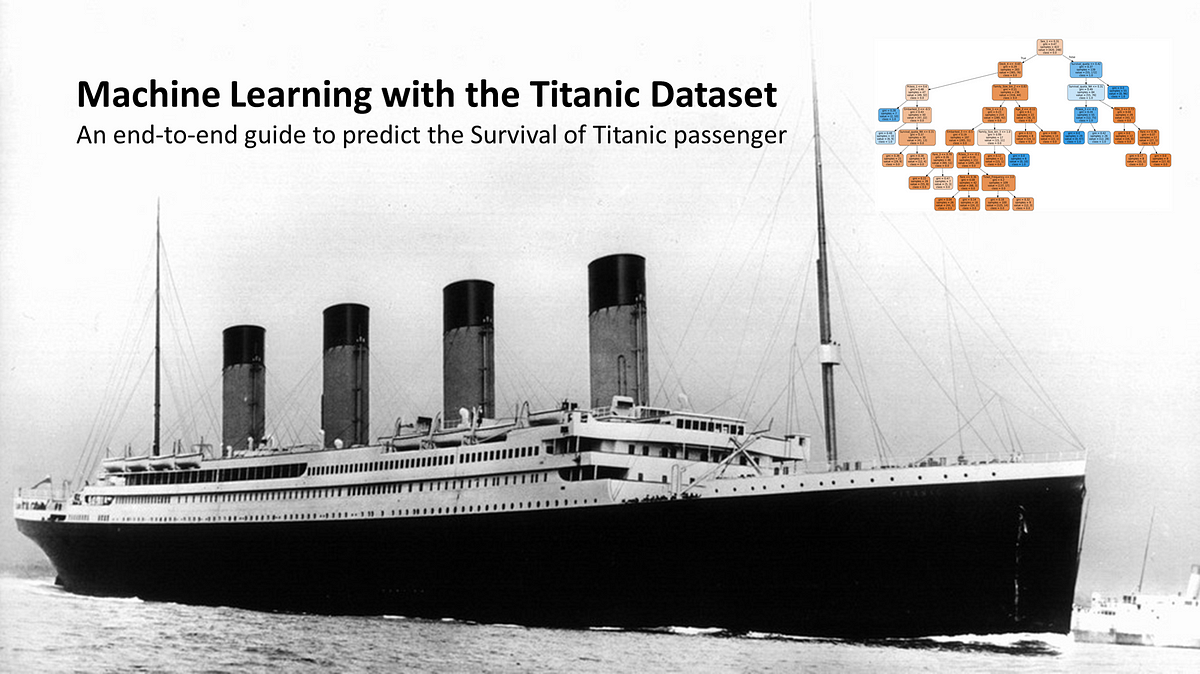

Makine öğrenmesi dünyasının meşhur problemi (bir proje) olan Titanic data seti ile tanışmaya hoş geldiniz arkadaşlar. Bu projemiz bir Kaggle Projesi olup sıklıkla kullanılan bir gerçek dünya data setidir. Data seti ile ilgili açıklamaya alttaki linkten ulaşabilirsiniz.


Bu problemde amacımız yukarıdaki linkteki görevi yerine getirmek.

**Önemli Not:** Kaggle yarışmalarında bazen data,
* train data
* test data
olarak ayrı verilir.

Buradaki test data bizim model oluştururken kullanacağımız test data değildir.

Bu test data Kaggle'in yarışma sonuçları test etmek için kullandığı datadır.

Dolayısı ile bu test data içinde target variable yani gerçek label değeri (grand truth) bulunmaz.

Bu sebeple kendi model doğruluğumuzu ölçerken bu test datayı kullanamayacağınızdan mevcut train data ile train_test_split yaparak kendi test datanızı oluşturmayı unutmayın!

## Import Library

In [50]:
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.float_format", lambda x: f"{x:.3f}")


## Read Data

In [54]:
df = pd.read_csv("train.csv")

In [56]:
df1 = df.copy()  

## Data Preparation

In [59]:
df.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex    Age  SibSp  \
0                            Braund, Mr. Owen Harris    male 22.000      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1   
2                             Heikkinen, Miss. Laina  female 26.000      0   

   Parch            Ticket   Fare Cabin Embarked  
0      0         A/5 21171  7.250   NaN        S  
1      0          PC 17599 71.283   C85        C  
2      0  STON/O2. 3101282  7.925   NaN        S

In [61]:
df.tail(3)

PassengerId  Survived  Pclass                                      Name  \
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
888  female    NaN      1      2  W./C. 6607 23.450   NaN        S  
889    male 26.000      0      0      111369 30.000  C148        C  
890    male 32.000      0      0      370376  7.750   NaN        Q

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [65]:
df.describe().T

count    mean     std   min     25%     50%     75%     max
PassengerId 891.000 446.000 257.354 1.000 223.500 446.000 668.500 891.000
Survived    891.000   0.384   0.487 0.000   0.000   0.000   1.000   1.000
Pclass      891.000   2.309   0.836 1.000   2.000   3.000   3.000   3.000
Age         714.000  29.699  14.526 0.420  20.125  28.000  38.000  80.000
SibSp       891.000   0.523   1.103 0.000   0.000   0.000   1.000   8.000
Parch       891.000   0.382   0.806 0.000   0.000   0.000   0.000   6.000
Fare        891.000  32.204  49.693 0.000   7.910  14.454  31.000 512.329

## Exploratory Data Analysis (EDA)

In [69]:
df.isnull().sum().sort_values(ascending=False)


Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [71]:
df.drop(columns=["Cabin"], inplace=True)
df["Age"] = df["Age"].fillna(df.groupby("Pclass")["Age"].transform("median"))
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])


In [73]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [75]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Length: 891, dtype: bool

In [77]:
df['Survived'].value_counts() 

Survived
0    549
1    342
Name: count, dtype: int64

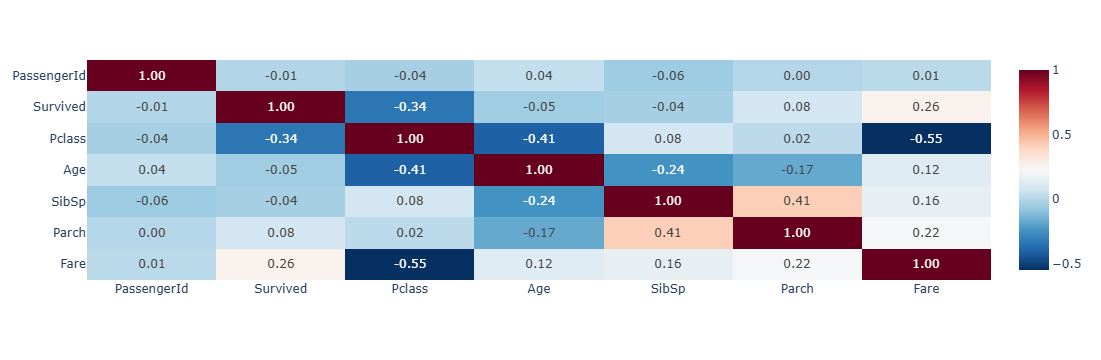

In [79]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

fig = px.imshow(corr_matrix, text_auto='.2f', aspect="auto", color_continuous_scale='RdBu_r')
fig.show()

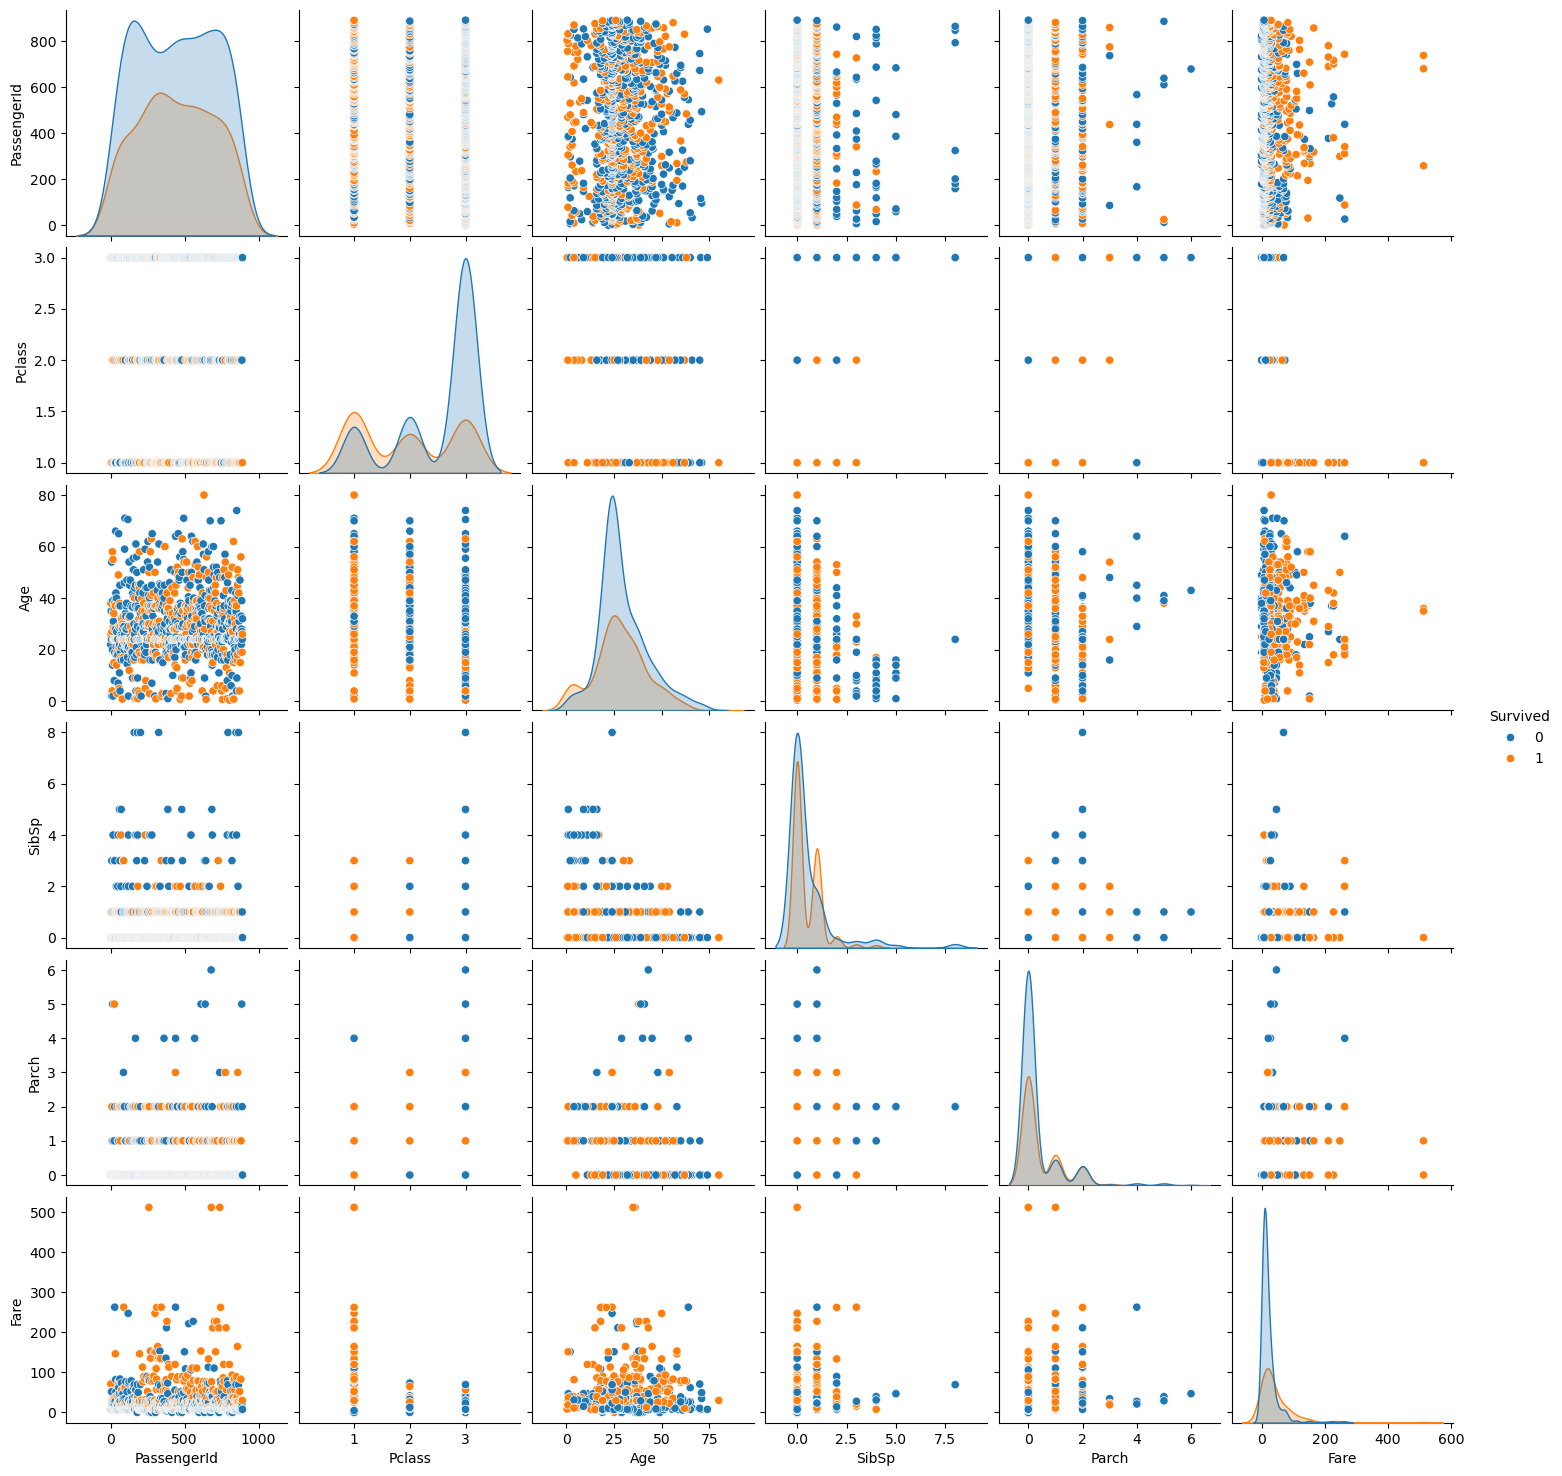

In [80]:
sns.pairplot(data=df, hue = "Survived" );  

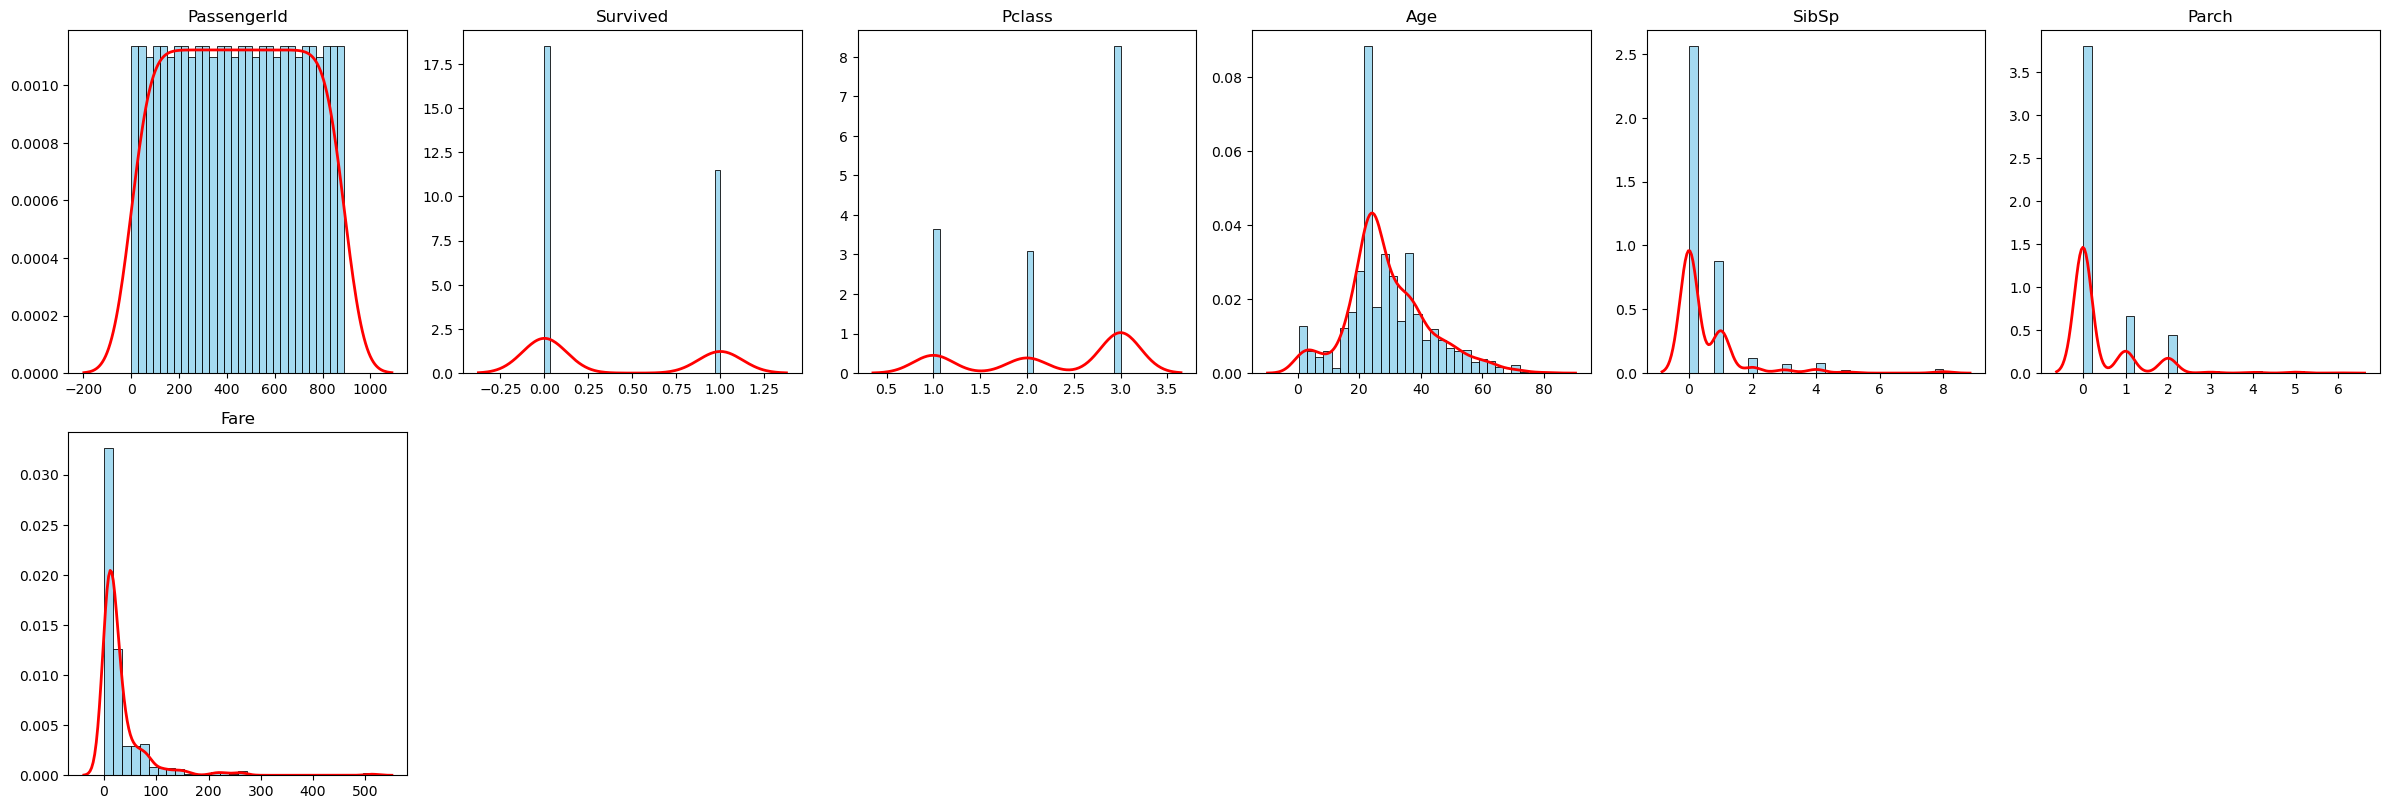

In [82]:
numeric_cols = df.select_dtypes(include='number').columns[:24]

fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(24, 16))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], ax=axes[i], stat='density', bins=30, color='skyblue', edgecolor='black')
    sns.kdeplot(df[col], ax=axes[i], color='red', linewidth=2)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [83]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
print(numeric_columns)


Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


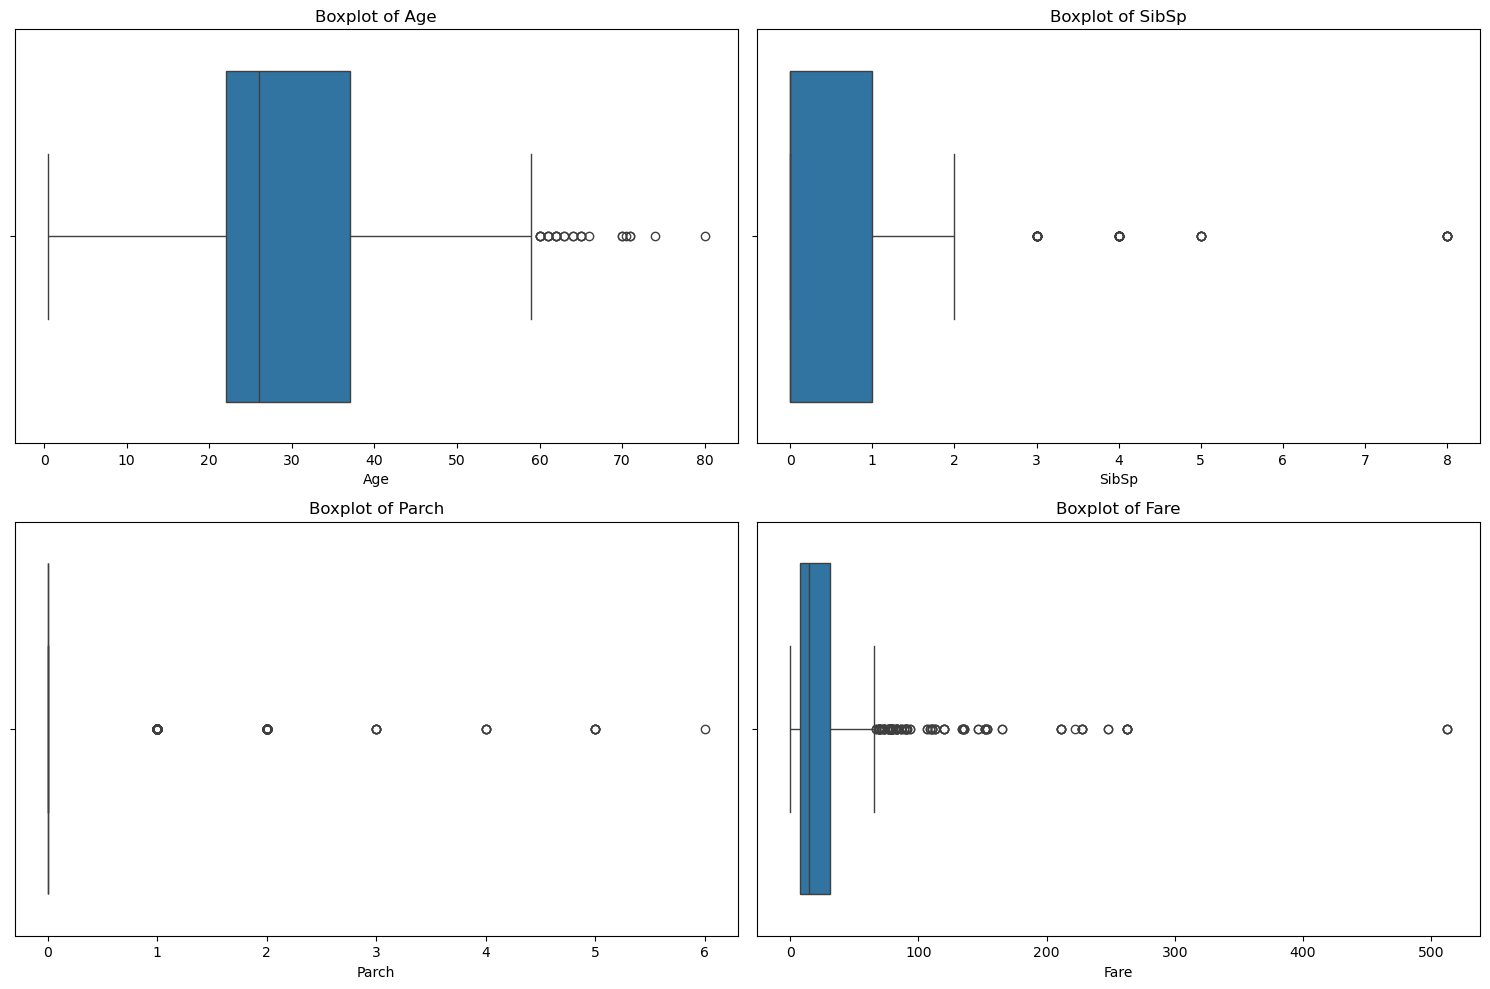

In [84]:
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


In [85]:
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']

for col in numeric_cols:
    print(f"--- {col} ---")
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Outlier değerlerini yazdırma
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print(f"Outliers:\n{outliers[[col]]}\n\n")


--- Age ---
Lower Bound: -0.5
Upper Bound: 59.5
Outliers:
       Age
33  66.000
54  65.000
96  71.000
116 70.500
170 61.000
252 62.000
275 63.000
280 65.000
326 61.000
366 60.000
438 64.000
456 65.000
483 63.000
493 71.000
545 64.000
555 62.000
570 62.000
587 60.000
625 61.000
630 80.000
672 70.000
684 60.000
694 60.000
745 70.000
829 62.000
851 74.000


--- SibSp ---
Lower Bound: -1.5
Upper Bound: 2.5
Outliers:
     SibSp
7        3
16       4
24       3
27       3
50       4
59       5
63       3
68       4
71       5
85       3
88       3
119      4
159      8
164      4
171      4
176      3
180      8
182      4
201      8
229      3
233      4
261      4
266      4
278      4
324      8
341      3
374      3
386      5
409      3
480      5
485      3
541      4
542      4
634      3
642      3
683      5
686      4
726      3
787      4
792      8
813      4
819      3
824      4
846      8
850      4
863      8


--- Parch ---
Lower Bound: 0.0
Upper Bound: 0.0
Outliers:
     Pa

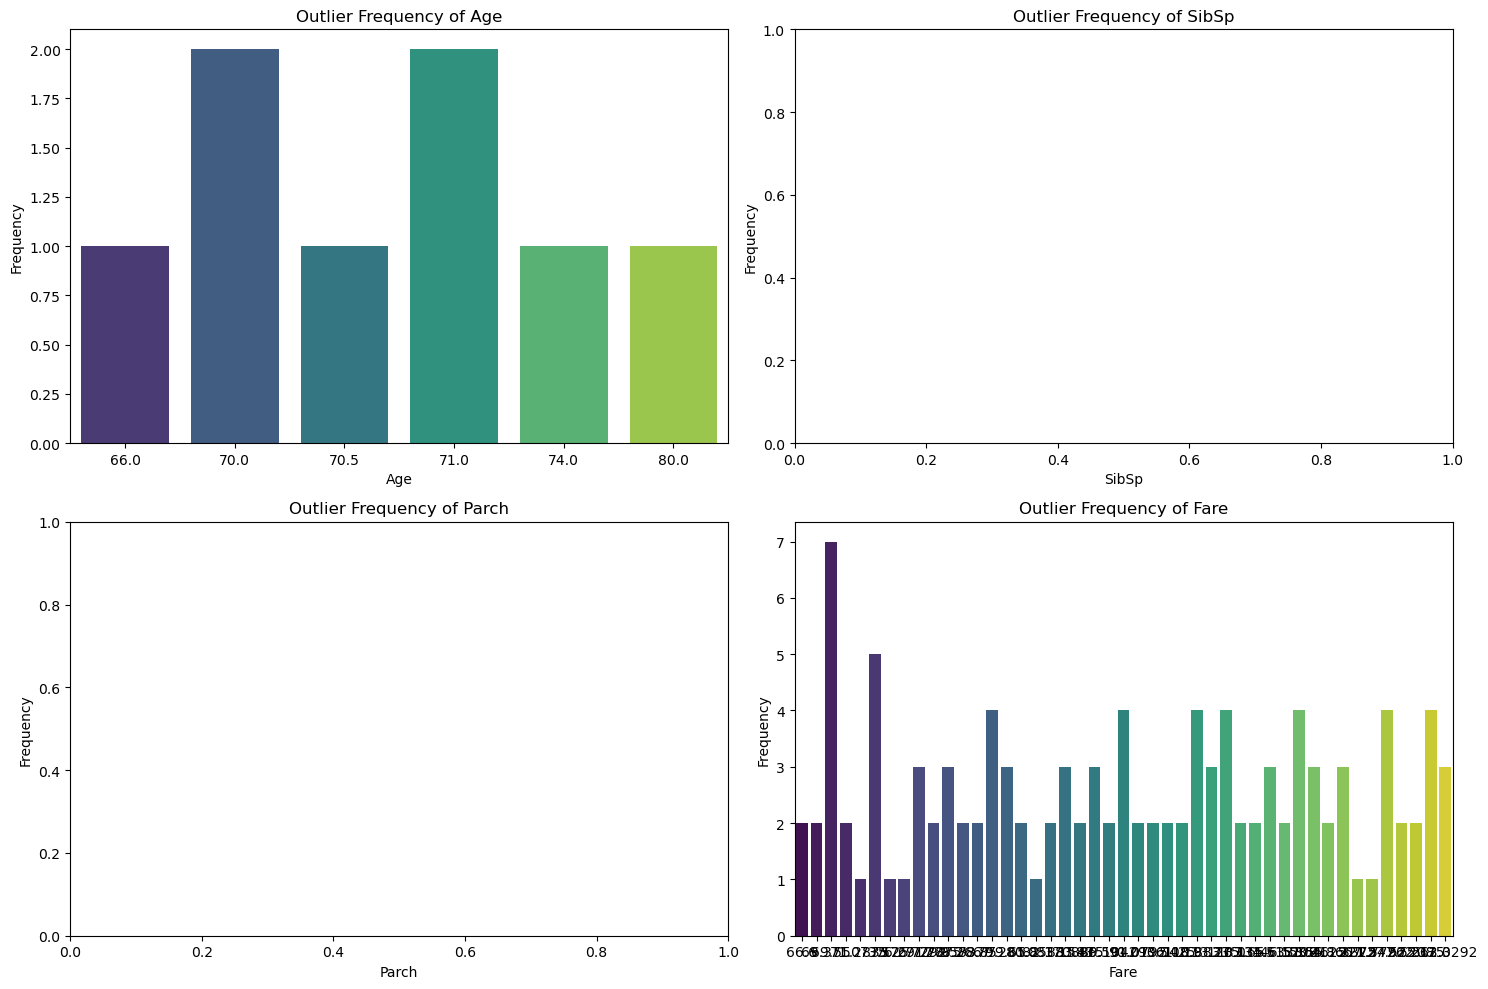

In [86]:
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']

plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    plt.subplot(2, 2, i)
    sns.countplot(x=outliers[col], palette='viridis')
    plt.title(f'Outlier Frequency of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


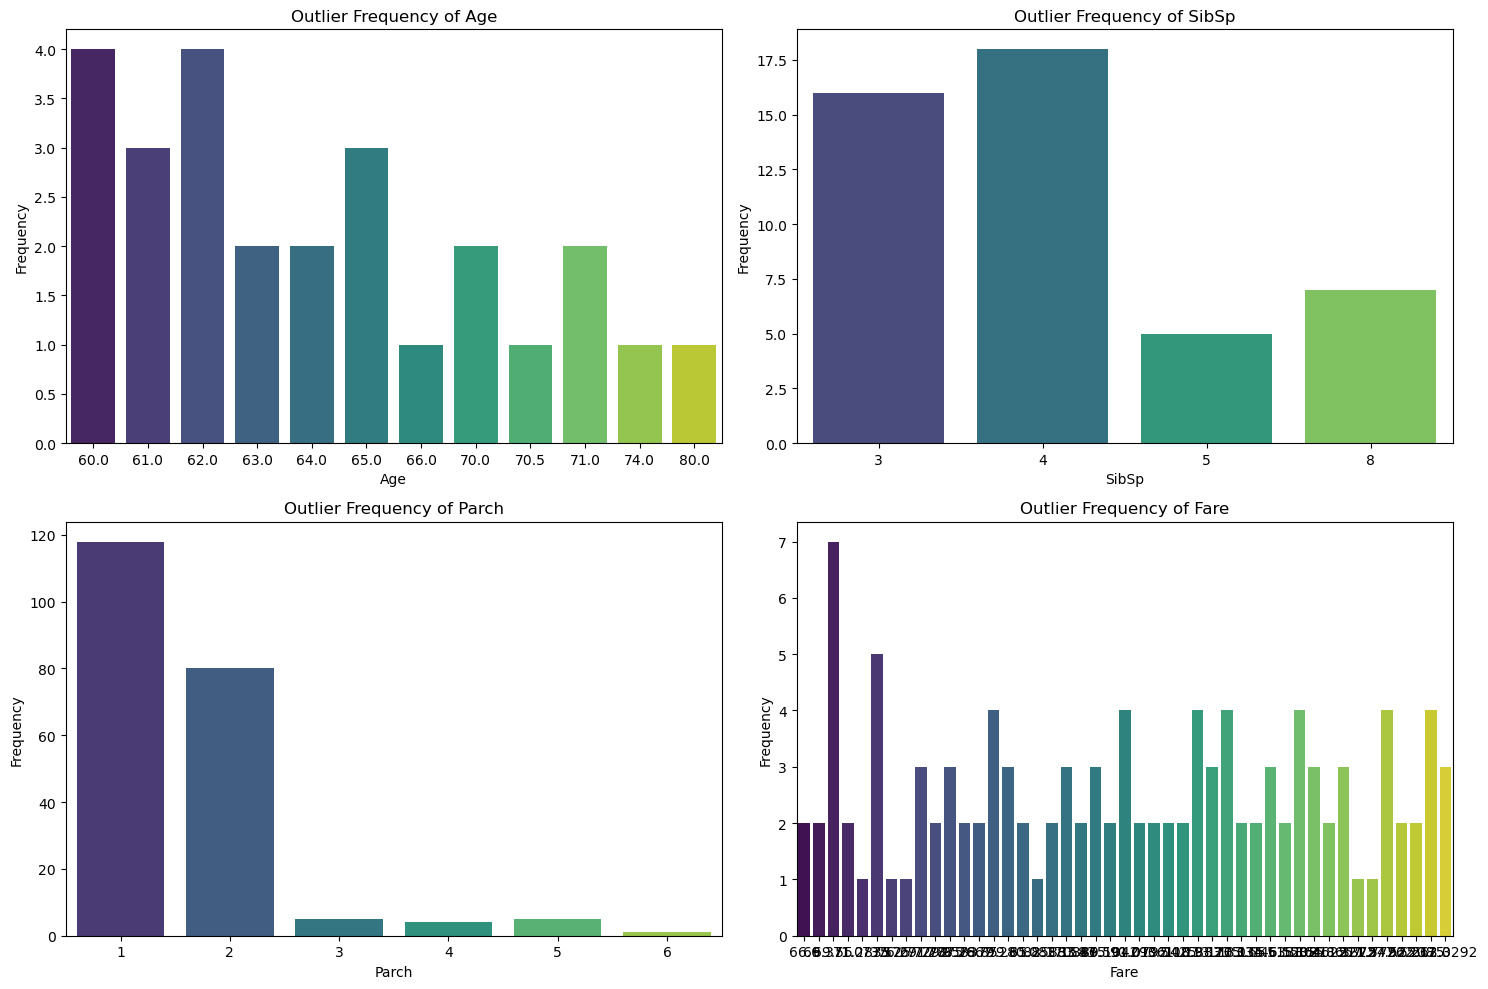

In [87]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    plt.subplot(2, 2, i)
    if not outliers.empty:
        sns.countplot(x=outliers[col], palette='viridis')
        plt.title(f'Outlier Frequency of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    else:
        plt.text(0.5, 0.5, f'No outliers in {col}', 
                 horizontalalignment='center', verticalalignment='center', 
                 fontsize=12)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [88]:
df.shape

(891, 11)

In [89]:
def kategorik(df, target='Survived'):
    import pandas as pd
    import numpy as np
    
    kategorik_kolonlar = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col in kategorik_kolonlar:
        print(f"\n--- {col.upper()} ---")
        print(f" Benzersiz Değer Sayısı: {df[col].nunique()}")
        print(f" Eksik Değer Sayısı: {df[col].isnull().sum()}")
        print("\n Kategori Dağılımı:")
        print(df[col].value_counts(dropna=False))
        print("\n Yüzdesel Dağılım:")
        print(df[col].value_counts(normalize=True, dropna=False) * 100)
        
        if target in df.columns:
            print(f"\n {target} Ortalaması (hayatta kalma oranı vs.):")
            print(df.groupby(col)[target].mean().sort_values(ascending=False))
        
        print("-" * 40)


In [90]:
kategorik(df)


--- NAME ---
 Benzersiz Değer Sayısı: 891
 Eksik Değer Sayısı: 0

 Kategori Dağılımı:
Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: count, Length: 891, dtype: int64

 Yüzdesel Dağılım:
Name
Braund, Mr. Owen Harris                    0.112
Boulos, Mr. Hanna                          0.112
Frolicher-Stehli, Mr. Maxmillian           0.112
Gilinski, Mr. Eliezer                      0.112
Murdlin, Mr. Joseph                        0.112
                                            ... 
Kelly, Miss. Anna Katherine "Annie Kate"   0

In [91]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [92]:
def eda_kategorik_tekil(df, column, target='Survived'):
    print(f"\n--- {column.upper()} ---")
    print(f" Benzersiz Değer Sayısı: {df[column].nunique()}")
    print(f" Eksik Değer Sayısı: {df[column].isnull().sum()}")

    print("\n Kategori Dağılımı:")
    print(df[column].value_counts())

    print("\n Yüzdesel Dağılım:")
    print(df[column].value_counts(normalize=True) * 100)

    if target in df.columns:
        print(f"\n {target} Ortalaması (hayatta kalma oranı):")
        print(df.groupby(column)[target].mean().sort_values(ascending=False))
        
    print("-" * 40)

eda_kategorik_tekil(df, 'Title')



--- TITLE ---
 Benzersiz Değer Sayısı: 17
 Eksik Değer Sayısı: 0

 Kategori Dağılımı:
Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

 Yüzdesel Dağılım:
Title
Mr         58.025
Miss       20.426
Mrs        14.029
Master      4.489
Dr          0.786
Rev         0.673
Mlle        0.224
Major       0.224
Col         0.224
Countess    0.112
Capt        0.112
Ms          0.112
Sir         0.112
Lady        0.112
Mme         0.112
Don         0.112
Jonkheer    0.112
Name: proportion, dtype: float64

 Survived Ortalaması (hayatta kalma oranı):
Title
Sir        1.000
Countess   1.000
Ms         1.000
Mme        1.000
Lady       1.000
Mlle       1.000
Mrs        0.792
Miss       0.698
Master     0.575
Col        0.500
Major      0.500
Dr    

In [105]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

df['Title'] = df['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs'
})

rare_female = ['Lady', 'Countess', 'Dona']
rare_male = ['Sir', 'Don', 'Jonkheer']
rare_general = ['Capt', 'Col', 'Dr', 'Major', 'Rev']

df['Title'] = df['Title'].replace(rare_female, 'Rare_Female')
df['Title'] = df['Title'].replace(rare_male, 'Rare_Male')
df['Title'] = df['Title'].replace(rare_general, 'Rare')



In [107]:
eda_kategorik_tekil(df, 'Title')



--- TITLE ---
 Benzersiz Değer Sayısı: 7
 Eksik Değer Sayısı: 0

 Kategori Dağılımı:
Title
Mr             517
Miss           185
Mrs            126
Master          40
Rare            18
Rare_Male        3
Rare_Female      2
Name: count, dtype: int64

 Yüzdesel Dağılım:
Title
Mr            58.025
Miss          20.763
Mrs           14.141
Master         4.489
Rare           2.020
Rare_Male      0.337
Rare_Female    0.224
Name: proportion, dtype: float64

 Survived Ortalaması (hayatta kalma oranı):
Title
Rare_Female   1.000
Mrs           0.794
Miss          0.703
Master        0.575
Rare_Male     0.333
Rare          0.278
Mr            0.157
Name: Survived, dtype: float64
----------------------------------------


In [109]:
df.shape

(891, 12)

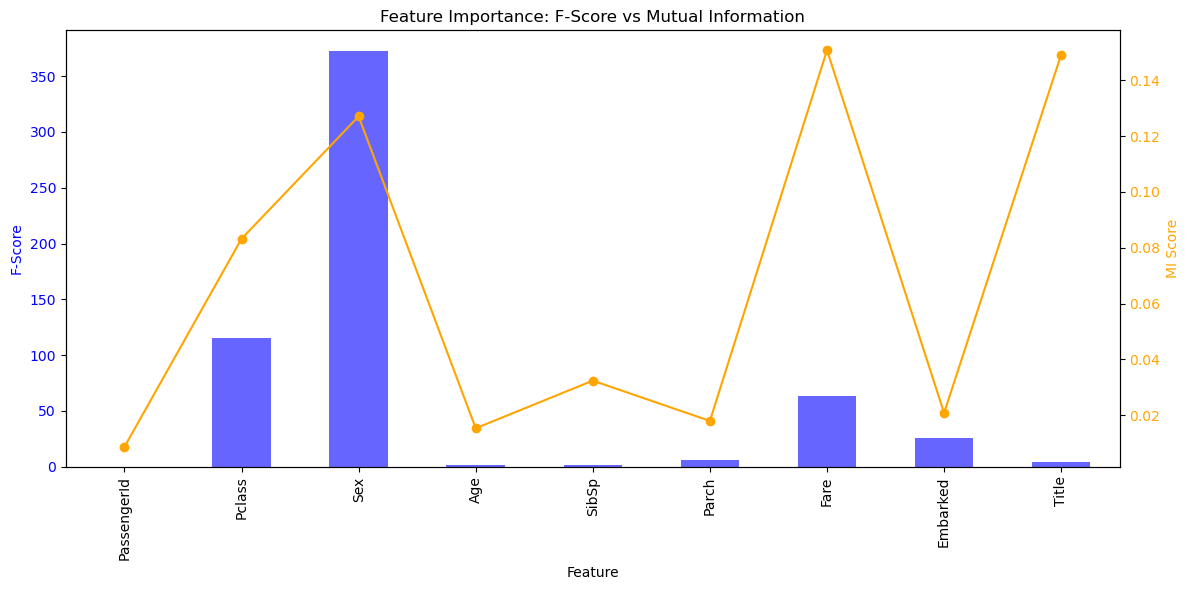


🔎 Özellik Önem Skorları (F-Score ve Mutual Information):
             F-Score  MI Score
Feature                       
Sex          372.406     0.127
Pclass       115.031     0.083
Fare          63.031     0.151
Embarked      25.717     0.021
Parch          5.963     0.018
Title          3.852     0.149
Age            1.990     0.015
SibSp          1.111     0.032
PassengerId    0.022     0.009
             F-Score  MI Score
Feature                       
Fare          63.031     0.151
Title          3.852     0.149
Sex          372.406     0.127
Pclass       115.031     0.083
SibSp          1.111     0.032
Embarked      25.717     0.021
Parch          5.963     0.018
Age            1.990     0.015
PassengerId    0.022     0.009


In [111]:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()

high_cardinality_cols = ['Name', 'Ticket']  # isteğe göre güncellenebilir
df_encoded = df_encoded.drop(columns=high_cardinality_cols)

categorical_cols = df_encoded.select_dtypes(include='object').columns

le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

X = df_encoded.drop("Survived", axis=1)
y = df_encoded["Survived"]

f_scores, _ = f_classif(X, y)
mi_scores = mutual_info_classif(X, y, discrete_features=False)

scores_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'MI Score': mi_scores
}).set_index('Feature')

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Features')
ax1.set_ylabel('F-Score', color='blue')
scores_df['F-Score'].plot(kind='bar', ax=ax1, color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('MI Score', color='orange')
scores_df['MI Score'].plot(kind='line', ax=ax2, color='orange', marker='o')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Feature Importance: F-Score vs Mutual Information')
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
plt.show()

print("\n🔎 Özellik Önem Skorları (F-Score ve Mutual Information):")
print(scores_df.sort_values(by='F-Score', ascending=False))

print(scores_df.sort_values(by='MI Score', ascending=False))


In [113]:
df.head(2)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex    Age  SibSp  \
0                            Braund, Mr. Owen Harris    male 22.000      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1   

   Parch     Ticket   Fare Embarked Title  
0      0  A/5 21171  7.250        S    Mr  
1      0   PC 17599 71.283        C   Mrs

In [117]:
df_model = df.copy()

df_model.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

categorical_cols = df_model.select_dtypes(include='object').columns
le = LabelEncoder()

for col in categorical_cols:
    df_model[col] = le.fit_transform(df_model[col])

print(df_model.head())


   Survived  Pclass  Sex    Age  SibSp  Parch   Fare  Embarked  Title
0         0       3    1 22.000      1      0  7.250         2      2
1         1       1    0 38.000      1      0 71.283         0      3
2         1       3    0 26.000      0      0  7.925         2      1
3         1       1    0 35.000      1      0 53.100         2      3
4         0       3    1 35.000      0      0  8.050         2      2


In [119]:
df_model.head(2)   

Survived  Pclass  Sex    Age  SibSp  Parch   Fare  Embarked  Title
0         0       3    1 22.000      1      0  7.250         2      2
1         1       1    0 38.000      1      0 71.283         0      3

In [137]:
import pandas as pd 
# Test verisini yükleyelim
df_test = pd.read_csv("test.csv")


In [139]:
passenger_ids = df_test['PassengerId'].copy()


In [141]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [143]:
df_test.head(3)

PassengerId  Pclass                              Name     Sex    Age  \
0          892       3                  Kelly, Mr. James    male 34.500   
1          893       3  Wilkes, Mrs. James (Ellen Needs)  female 47.000   
2          894       2         Myles, Mr. Thomas Francis    male 62.000   

   SibSp  Parch  Ticket  Fare Cabin Embarked  
0      0      0  330911 7.829   NaN        Q  
1      1      0  363272 7.000   NaN        S  
2      0      0  240276 9.688   NaN        Q

In [145]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [147]:
from sklearn.impute import SimpleImputer
df_test['Title'] = X['Title']

df_test = df_test.drop(["Name", "Ticket", "PassengerId", "Cabin"], axis=1)

print(df_test.isnull().sum())

df_test['Age'] = df_test['Age'].fillna(df_test['Age'].median())

le = LabelEncoder()

df_test['Sex'] = le.fit_transform(df_test['Sex'])
df_test['Embarked'] = le.fit_transform(df_test['Embarked'].fillna('S'))  # NaN olanları 'S' olarak kabul edebiliriz

df_test['Embarked'] = df_test['Embarked'].fillna(df_test['Embarked'].mode()[0])
imputer = SimpleImputer(strategy='median')
df_test['Fare'] = imputer.fit_transform(df_test[['Fare']])

from sklearn.impute import SimpleImputer

print(df_test.head())

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
Title        0
dtype: int64
   Pclass  Sex    Age  SibSp  Parch   Fare  Embarked  Title
0       3    1 34.500      0      0  7.829         1      2
1       3    0 47.000      1      0  7.000         2      3
2       2    1 62.000      0      0  9.688         1      1
3       3    1 27.000      0      0  8.662         2      3
4       3    0 22.000      1      1 12.287         2      2


In [149]:
df_test.head(3)

Pclass  Sex    Age  SibSp  Parch  Fare  Embarked  Title
0       3    1 34.500      0      0 7.829         1      2
1       3    0 47.000      1      0 7.000         2      3
2       2    1 62.000      0      0 9.688         1      1

In [151]:
print("Train Columns:")
print(df_model.columns)
print("\nTest Columns:")
print(df_test.columns)

print("\nTrain Data Types:")
print(df_model.dtypes)
print("\nTest Data Types:")
print(df_test.dtypes)


Train Columns:
Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title'],
      dtype='object')

Test Columns:
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title'], dtype='object')

Train Data Types:
Survived      int64
Pclass        int64
Sex           int32
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int32
Title         int32
dtype: object

Test Data Types:
Pclass        int64
Sex           int32
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int32
Title         int32
dtype: object


In [159]:
df_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
dtype: int64

In [155]:
print(f"Train set shape (df_model): {df_model.shape}")
print(f"Test set shape (df_test): {df_test.shape}")


Train set shape (df_model): (891, 9)
Test set shape (df_test): (418, 8)


## Train | Test Split

In [157]:
X = df_model.drop("Survived", axis=1)   
y = df_model["Survived"]           

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelling | Model Performance

## Adaboost

AdaBoost Classification Report (Grid Search Olmadan)
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



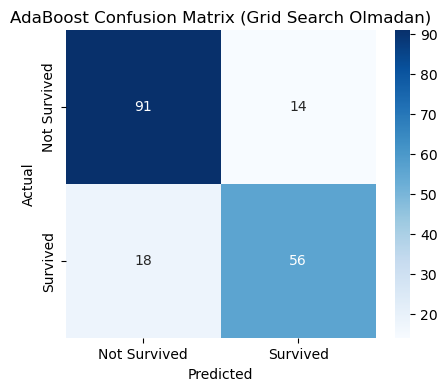

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  AdaBoost     0.821      0.800   0.757     0.778    0.875

In [161]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


ada_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', AdaBoostClassifier(random_state=42))
])

ada_pipeline.fit(X_train, y_train)

y_pred_ada = ada_pipeline.predict(X_valid)
y_proba_ada = ada_pipeline.predict_proba(X_valid)[:, 1]

ada_metrics = {
    'Model': 'AdaBoost',
    'Accuracy': accuracy_score(y_valid, y_pred_ada),
    'Precision': precision_score(y_valid, y_pred_ada),
    'Recall': recall_score(y_valid, y_pred_ada),
    'F1 Score': f1_score(y_valid, y_pred_ada),
    'ROC AUC': roc_auc_score(y_valid, y_proba_ada)
}

print("AdaBoost Classification Report (Grid Search Olmadan)")
print(classification_report(y_valid, y_pred_ada))

cm = confusion_matrix(y_valid, y_pred_ada)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('AdaBoost Confusion Matrix (Grid Search Olmadan)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

pd.DataFrame([ada_metrics])


In [167]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

ada_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', AdaBoostClassifier(random_state=42))
])

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results_ada = cross_validate(ada_pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False)

print("AdaBoost (Vanilla) - 10-Fold CV Sonuçları:")
for metric in scoring:
    scores = cv_results_ada[f'test_{metric}']
    print(f"{metric.upper():<10}: {np.mean(scores):.4f} (std: {np.std(scores):.4f})")


AdaBoost (Vanilla) - 10-Fold CV Sonuçları:
ACCURACY  : 0.8260 (std: 0.0347)
PRECISION : 0.7960 (std: 0.0523)
RECALL    : 0.7395 (std: 0.0819)
F1        : 0.7637 (std: 0.0521)
ROC_AUC   : 0.8662 (std: 0.0433)


AdaBoost Classification Report (Depth=3)
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       105
           1       0.78      0.81      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



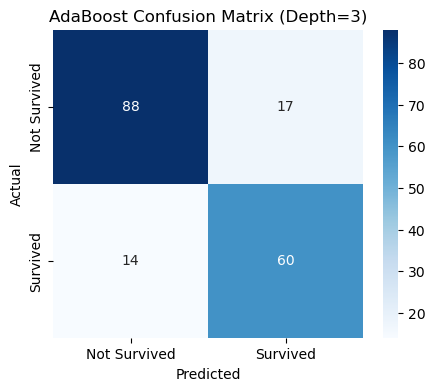

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  AdaBoost (Depth=3)     0.827      0.779   0.811     0.795    0.877

In [169]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

ada_pipeline_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('model', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), random_state=42))
])

ada_params = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.5, 1.0, 1.5]
}


ada_grid = GridSearchCV(ada_pipeline_grid, ada_params, cv=10, scoring='roc_auc', n_jobs=-1)
ada_grid.fit(X_train, y_train)

best_ada = ada_grid.best_estimator_
y_pred_ada_best = best_ada.predict(X_valid)
y_proba_ada_best = best_ada.predict_proba(X_valid)[:, 1]

ada_metrics_best = {
    'Model': 'AdaBoost (Depth=3)',
    'Accuracy': accuracy_score(y_valid, y_pred_ada_best),
    'Precision': precision_score(y_valid, y_pred_ada_best),
    'Recall': recall_score(y_valid, y_pred_ada_best),
    'F1 Score': f1_score(y_valid, y_pred_ada_best),
    'ROC AUC': roc_auc_score(y_valid, y_proba_ada_best)
}

# Rapor
print("AdaBoost Classification Report (Depth=3)")
print(classification_report(y_valid, y_pred_ada_best))

# Confusion Matrix
cm_best = confusion_matrix(y_valid, y_pred_ada_best)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('AdaBoost Confusion Matrix (Depth=3)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Sonuçları göster
pd.DataFrame([ada_metrics_best])


In [171]:
print("En iyi hiperparametreler:")
print(ada_grid.best_params_)


En iyi hiperparametreler:
{'model__learning_rate': 1.0, 'model__n_estimators': 50}


In [189]:
final_ada_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=50,
        learning_rate=1.0,
        random_state=42
    ))
])

final_ada_model.fit(X, y)



Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                    random_state=42))])

 # XGBoost

XGBoost Classification Report (Grid Search Olmadan)
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



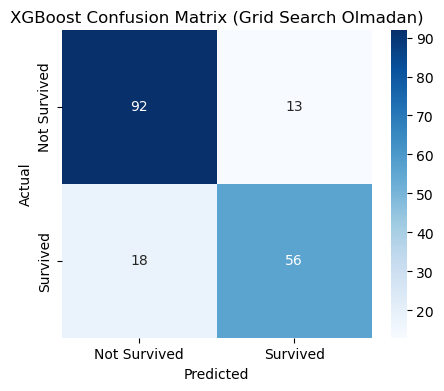

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  XGBoost     0.827      0.812   0.757     0.783    0.895

In [175]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_valid)
y_proba_xgb = xgb_pipeline.predict_proba(X_valid)[:, 1]

xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_valid, y_pred_xgb),
    'Precision': precision_score(y_valid, y_pred_xgb),
    'Recall': recall_score(y_valid, y_pred_xgb),
    'F1 Score': f1_score(y_valid, y_pred_xgb),
    'ROC AUC': roc_auc_score(y_valid, y_proba_xgb)
}

print("XGBoost Classification Report (Grid Search Olmadan)")
print(classification_report(y_valid, y_pred_xgb))

# Confusion matrix
cm = confusion_matrix(y_valid, y_pred_xgb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('XGBoost Confusion Matrix (Grid Search Olmadan)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

pd.DataFrame([xgb_metrics])


In [177]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Pipeline: Scaling + XGBoost (vanilla)
xgb_vanilla_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

# 2. CV ayarları
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 3. Skor metrikleri
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score)
}

# 4. Cross-validation
cv_results_xgb = cross_validate(xgb_vanilla_pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)

# 5. Sonuçları Yazdır
print("XGBoost (Vanilla) - 10-Fold CV Sonuçları:")
for metric in scoring.keys():
    scores = cv_results_xgb[f'test_{metric}']
    print(f"{metric.upper():10}: {scores.mean():.4f} (std: {scores.std():.4f})")



XGBoost (Vanilla) - 10-Fold CV Sonuçları:
ACCURACY  : 0.8193 (std: 0.0222)
PRECISION : 0.7836 (std: 0.0430)
RECALL    : 0.7398 (std: 0.0877)
F1        : 0.7565 (std: 0.0399)
ROC_AUC   : 0.8044 (std: 0.0312)


📌 XGBoost Classification Report (Grid Search ile)
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



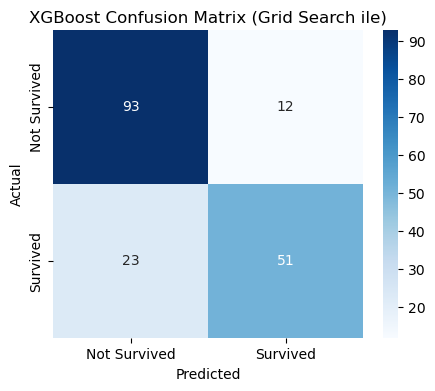

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  XGBoost (Optimized)     0.804      0.810   0.689     0.745    0.888

In [179]:
xgb_pipeline_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

xgb_params = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.05, 0.1, 0.15],
    'model__max_depth': [3, 5, 7]
}

xgb_grid = GridSearchCV(xgb_pipeline_grid, xgb_params, cv=5, scoring='roc_auc', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_
y_pred_xgb_best = best_xgb.predict(X_valid)
y_proba_xgb_best = best_xgb.predict_proba(X_valid)[:, 1]

xgb_metrics_best = {
    'Model': 'XGBoost (Optimized)',
    'Accuracy': accuracy_score(y_valid, y_pred_xgb_best),
    'Precision': precision_score(y_valid, y_pred_xgb_best),
    'Recall': recall_score(y_valid, y_pred_xgb_best),
    'F1 Score': f1_score(y_valid, y_pred_xgb_best),
    'ROC AUC': roc_auc_score(y_valid, y_proba_xgb_best)
}

print("📌 XGBoost Classification Report (Grid Search ile)")
print(classification_report(y_valid, y_pred_xgb_best))

cm_best = confusion_matrix(y_valid, y_pred_xgb_best)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('XGBoost Confusion Matrix (Grid Search ile)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

pd.DataFrame([xgb_metrics_best])

In [181]:
final_xgb_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_xgb)  
])


#  Gradient Boosting Modeli

📌 GradientBoosting Classification Report (Pre-GridSearch)
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



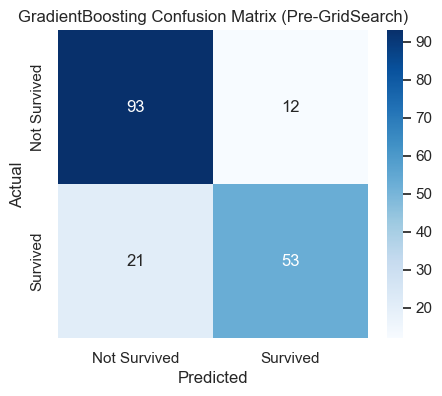

Model  Accuracy  Precision  Recall  F1 Score  \
0  GradientBoosting (Pre-GridSearch)     0.816      0.815   0.716     0.763   

   ROC AUC  
0    0.905

In [122]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


gbc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier(random_state=42))
])

gbc_pipeline.fit(X_train, y_train)

y_pred_gbc = gbc_pipeline.predict(X_valid)
y_proba_gbc = gbc_pipeline.predict_proba(X_valid)[:, 1]

gbc_metrics = {
    'Model': 'GradientBoosting (Pre-GridSearch)',
    'Accuracy': accuracy_score(y_valid, y_pred_gbc),
    'Precision': precision_score(y_valid, y_pred_gbc),
    'Recall': recall_score(y_valid, y_pred_gbc),
    'F1 Score': f1_score(y_valid, y_pred_gbc),
    'ROC AUC': roc_auc_score(y_valid, y_proba_gbc)
}

print("GradientBoosting Classification Report (Pre-GridSearch)")
print(classification_report(y_valid, y_pred_gbc))

cm = confusion_matrix(y_valid, y_pred_gbc)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('GradientBoosting Confusion Matrix (Pre-GridSearch)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

pd.DataFrame([gbc_metrics])


In [124]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np


gbc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(gbc_pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

accuracy_scores = cross_val_score(gbc_pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
precision_scores = cross_val_score(gbc_pipeline, X_train, y_train, cv=cv, scoring='precision', n_jobs=-1)
recall_scores = cross_val_score(gbc_pipeline, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1)
f1_scores = cross_val_score(gbc_pipeline, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)

print("GradientBoosting Model - 10-Fold Cross Validation Results:")

print(f"Mean ROC AUC: {round(np.mean(cv_scores), 4)}")

print(f"Accuracy: {round(np.mean(accuracy_scores), 4)}")
print(f"Precision: {round(np.mean(precision_scores), 4)}")
print(f"Recall: {round(np.mean(recall_scores), 4)}")
print(f"F1 Score: {round(np.mean(f1_scores), 4)}")


📊 GradientBoosting Model - 10-Fold Cross Validation Results:
Mean ROC AUC: 0.8691
Accuracy: 0.8161
Precision: 0.8106
Recall: 0.6792
F1 Score: 0.7344


📌 GradientBoosting Classification Report (Post-GridSearch)
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



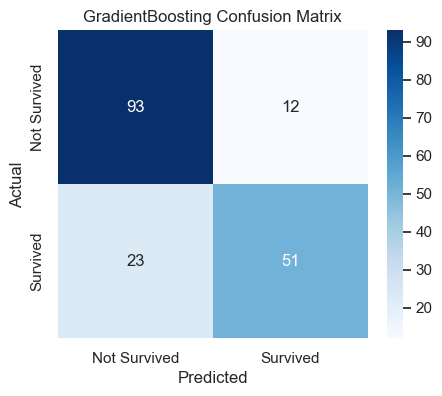

              Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  GradientBoosting     0.804      0.810   0.689     0.745    0.888
ROC AUC Score: 0.8880308880308881


In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

gbc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier(random_state=42))
])

gbc_params = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.05, 0.1, 0.15],
    'model__max_depth': [3, 5, 7]
}

gbc_grid = GridSearchCV(gbc_pipeline, gbc_params, cv=5, scoring='roc_auc', n_jobs=-1)
gbc_grid.fit(X_train, y_train)

best_gbc = gbc_grid.best_estimator_
y_pred_gbc_best = best_gbc.predict(X_valid)
y_proba_gbc_best = best_gbc.predict_proba(X_valid)[:, 1]

gbc_metrics_best = {
    'Model': 'GradientBoosting',
    'Accuracy': accuracy_score(y_valid, y_pred_gbc_best),
    'Precision': precision_score(y_valid, y_pred_gbc_best),
    'Recall': recall_score(y_valid, y_pred_gbc_best),
    'F1 Score': f1_score(y_valid, y_pred_gbc_best),
    'ROC AUC': roc_auc_score(y_valid, y_proba_gbc_best)
}

print("GradientBoosting Classification Report (Post-GridSearch)")
print(classification_report(y_valid, y_pred_gbc_best))

cm = confusion_matrix(y_valid, y_pred_gbc_best)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('GradientBoosting Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

gbc_metrics_post_grid = pd.DataFrame([gbc_metrics_best])

print(gbc_metrics_post_grid)  # Bu satır eklenmeli

print(f"ROC AUC Score: {gbc_metrics_best['ROC AUC']}")


In [128]:
final_gbc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier(random_state=42))
])

final_gbc_pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=42))])

# LightGBM

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


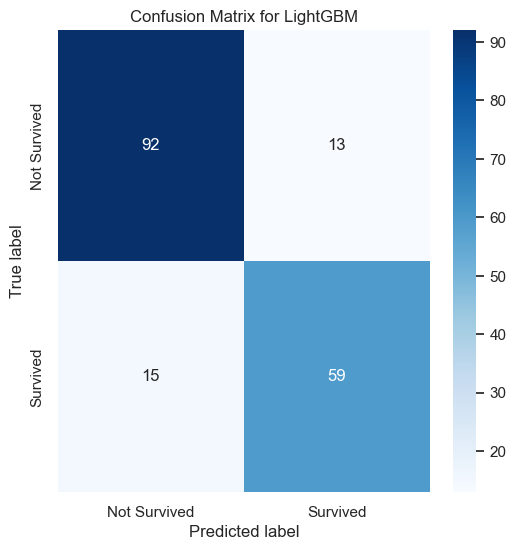

In [131]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

lgb_model = lgb.LGBMClassifier(random_state=42)

lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_valid)
y_proba_lgb = lgb_model.predict_proba(X_valid)[:, 1]

accuracy_lgb = accuracy_score(y_valid, y_pred_lgb)
precision_lgb = precision_score(y_valid, y_pred_lgb)
recall_lgb = recall_score(y_valid, y_pred_lgb)
f1_lgb = f1_score(y_valid, y_pred_lgb)
roc_auc_lgb = roc_auc_score(y_valid, y_proba_lgb)

print("Model: LightGBM")
print(f"Accuracy  : {accuracy_lgb:.4f}")
print(f"Precision : {precision_lgb:.4f}")
print(f"Recall    : {recall_lgb:.4f}")
print(f"F1 Score  : {f1_lgb:.4f}")
print(f"ROC AUC   : {roc_auc_lgb:.4f}")
print("\n Classification Report:")
print(classification_report(y_valid, y_pred_lgb))

cm_lgb = confusion_matrix(y_valid, y_pred_lgb)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for LightGBM')
plt.show()


In [133]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm as lgb
import numpy as np

lgb_model = lgb.LGBMClassifier(random_state=42)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score),
}

cv_results = cross_validate(lgb_model, X, y, cv=cv, scoring=scoring)

print("LightGBM (Vanilla) 10-Fold CV Skorları:")
for metric in scoring.keys():
    print(f"{metric.upper():10}: {cv_results['test_' + metric].mean():.4f} (std: {cv_results['test_' + metric].std():.4f})")


[LightGBM] [Info] Number of positive: 307, number of negative: 494
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383271 -> initscore=-0.475688
[LightGBM] [Info] Start training from score -0.475688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


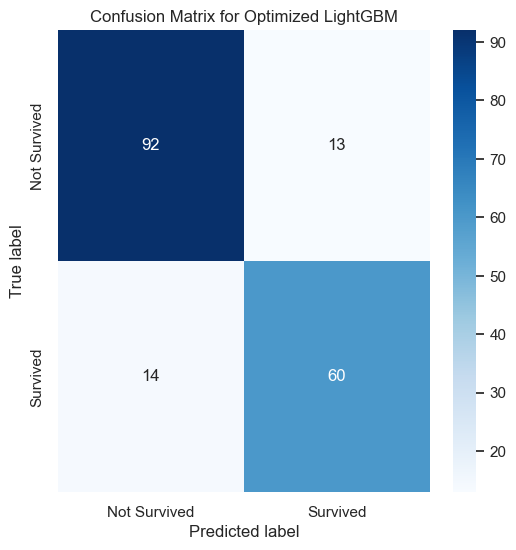

In [136]:
from sklearn.model_selection import GridSearchCV

lgb_model_grid = lgb.LGBMClassifier(random_state=42)

param_grid_lgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search_lgb = GridSearchCV(estimator=lgb_model_grid, param_grid=param_grid_lgb, cv=5, n_jobs=-1, scoring='roc_auc')

grid_search_lgb.fit(X_train, y_train)

best_params_lgb = grid_search_lgb.best_params_
print("\nEn iyi parametreler:", best_params_lgb)

best_lgb_model = grid_search_lgb.best_estimator_
y_pred_lgb_best = best_lgb_model.predict(X_valid)
y_proba_lgb_best = best_lgb_model.predict_proba(X_valid)[:, 1]

accuracy_lgb_best = accuracy_score(y_valid, y_pred_lgb_best)
precision_lgb_best = precision_score(y_valid, y_pred_lgb_best)
recall_lgb_best = recall_score(y_valid, y_pred_lgb_best)
f1_lgb_best = f1_score(y_valid, y_pred_lgb_best)
roc_auc_lgb_best = roc_auc_score(y_valid, y_proba_lgb_best)

print("\n Optimized LightGBM")
print(f"Accuracy  : {accuracy_lgb_best:.4f}")
print(f"Precision : {precision_lgb_best:.4f}")
print(f"Recall    : {recall_lgb_best:.4f}")
print(f"F1 Score  : {f1_lgb_best:.4f}")
print(f"ROC AUC   : {roc_auc_lgb_best:.4f}")
print("\n Classification Report:")
print(classification_report(y_valid, y_pred_lgb_best))

cm_lgb_best = confusion_matrix(y_valid, y_pred_lgb_best)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_lgb_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Optimized LightGBM')
plt.show()


In [138]:
final_model_lgb = best_lgb_model

# Catboost

📌 Model: CatBoost
Accuracy  : 0.8212
Precision : 0.8088
Recall    : 0.7432
F1 Score  : 0.7746
ROC AUC   : 0.9035

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



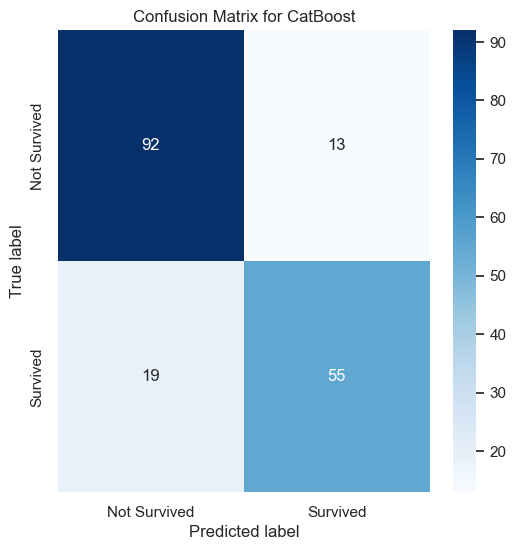

In [141]:
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

catboost_model = CatBoostClassifier(random_state=42, verbose=0)

catboost_model.fit(X_train, y_train)

y_pred_catboost = catboost_model.predict(X_valid)
y_proba_catboost = catboost_model.predict_proba(X_valid)[:, 1]

accuracy_catboost = accuracy_score(y_valid, y_pred_catboost)
precision_catboost = precision_score(y_valid, y_pred_catboost)
recall_catboost = recall_score(y_valid, y_pred_catboost)
f1_catboost = f1_score(y_valid, y_pred_catboost)
roc_auc_catboost = roc_auc_score(y_valid, y_proba_catboost)

print(" Model: CatBoost")
print(f"Accuracy  : {accuracy_catboost:.4f}")
print(f"Precision : {precision_catboost:.4f}")
print(f"Recall    : {recall_catboost:.4f}")
print(f"F1 Score  : {f1_catboost:.4f}")
print(f"ROC AUC   : {roc_auc_catboost:.4f}")
print("\n Classification Report:")
print(classification_report(y_valid, y_pred_catboost))

cm_catboost = confusion_matrix(y_valid, y_pred_catboost)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_catboost, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for CatBoost')
plt.show()


In [143]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer

catboost_model_cv = CatBoostClassifier(random_state=42, verbose=0)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score)
}

cv_results_catboost = cross_validate(catboost_model_cv, X, y, cv=cv, scoring=scoring)

print("10-Fold CV Skorları:")
for metric in scoring.keys():
    mean_score = cv_results_catboost[f'test_{metric}'].mean()
    std_score = cv_results_catboost[f'test_{metric}'].std()
    print(f"{metric.upper():10}: {mean_score:.4f} (std: {std_score:.4f})")


📊 CatBoost (Vanilla) 10-Fold CV Skorları:
ACCURACY  : 0.8327 (std: 0.0212)
PRECISION : 0.8258 (std: 0.0341)
RECALL    : 0.7194 (std: 0.0825)
F1        : 0.7652 (std: 0.0412)
ROC_AUC   : 0.8115 (std: 0.0316)



En iyi parametreler: {'depth': 9, 'iterations': 300, 'learning_rate': 0.01}

📌 Optimized CatBoost
Accuracy  : 0.8324
Precision : 0.8235
Recall    : 0.7568
F1 Score  : 0.7887
ROC AUC   : 0.8938

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       105
           1       0.82      0.76      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



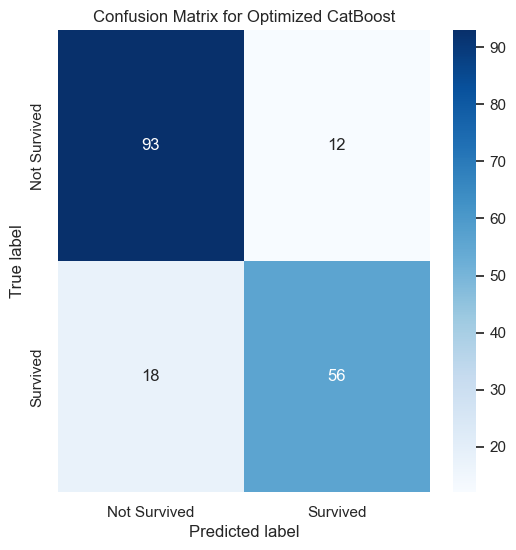

In [145]:
from sklearn.model_selection import GridSearchCV

catboost_model_grid = CatBoostClassifier(random_state=42, verbose=0)

param_grid_catboost = {
    'iterations': [200, 300],
    'learning_rate': [0.01, 0.1],
    'depth': [5, 7, 9]
}

grid_search_catboost = GridSearchCV(estimator=catboost_model_grid, param_grid=param_grid_catboost, cv=5, n_jobs=-1, scoring='roc_auc')

grid_search_catboost.fit(X_train, y_train)

best_params_catboost = grid_search_catboost.best_params_
print("\nEn iyi parametreler:", best_params_catboost)

best_catboost_model = grid_search_catboost.best_estimator_
y_pred_catboost_best = best_catboost_model.predict(X_valid)
y_proba_catboost_best = best_catboost_model.predict_proba(X_valid)[:, 1]

accuracy_catboost_best = accuracy_score(y_valid, y_pred_catboost_best)
precision_catboost_best = precision_score(y_valid, y_pred_catboost_best)
recall_catboost_best = recall_score(y_valid, y_pred_catboost_best)
f1_catboost_best = f1_score(y_valid, y_pred_catboost_best)
roc_auc_catboost_best = roc_auc_score(y_valid, y_proba_catboost_best)

print("\n CatBoost")
print(f"Accuracy  : {accuracy_catboost_best:.4f}")
print(f"Precision : {precision_catboost_best:.4f}")
print(f"Recall    : {recall_catboost_best:.4f}")
print(f"F1 Score  : {f1_catboost_best:.4f}")
print(f"ROC AUC   : {roc_auc_catboost_best:.4f}")
print("\n Classification Report:")
print(classification_report(y_valid, y_pred_catboost_best))

cm_catboost_best = confusion_matrix(y_valid, y_pred_catboost_best)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_catboost_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix ')
plt.show()


In [147]:
final_model_catboost = grid_search_catboost.best_estimator_


# ML Model Evaluation and Comparison
 

In [150]:
import pandas as pd

results = {
    'Model': ['AdaBoost (Depth=3)', 'XGBoost (Optimized)', 'GradientBoosting', 'LightGBM', 'CatBoost'],
    'Accuracy': [0.827, 0.804, 0.804, 0.8492, 0.8324],
    'Precision': [0.779, 0.810, 0.810, 0.8219, 0.8235],
    'Recall': [0.811, 0.689, 0.689, 0.8108, 0.7568],
    'F1 Score': [0.795, 0.745, 0.745, 0.8163, 0.7887],
    'ROC AUC': [0.877, 0.888, 0.888, 0.8985, 0.8938]
}

df_results = pd.DataFrame(results)

print(df_results.sort_values(by='Accuracy', ascending=False))


                 Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
3             LightGBM     0.849      0.822   0.811     0.816    0.898
4             CatBoost     0.832      0.824   0.757     0.789    0.894
0   AdaBoost (Depth=3)     0.827      0.779   0.811     0.795    0.877
1  XGBoost (Optimized)     0.804      0.810   0.689     0.745    0.888
2     GradientBoosting     0.804      0.810   0.689     0.745    0.888


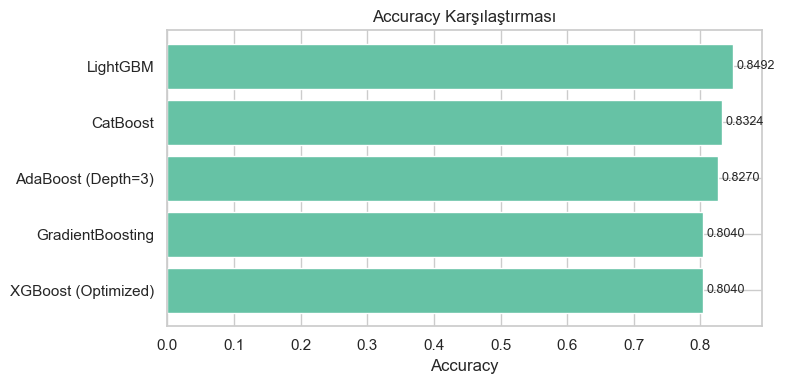

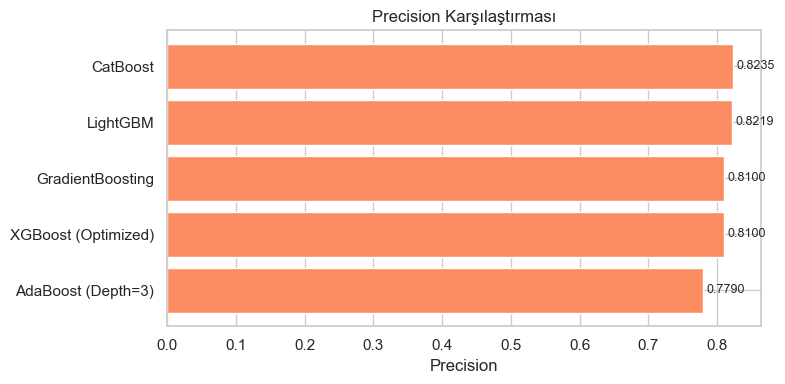

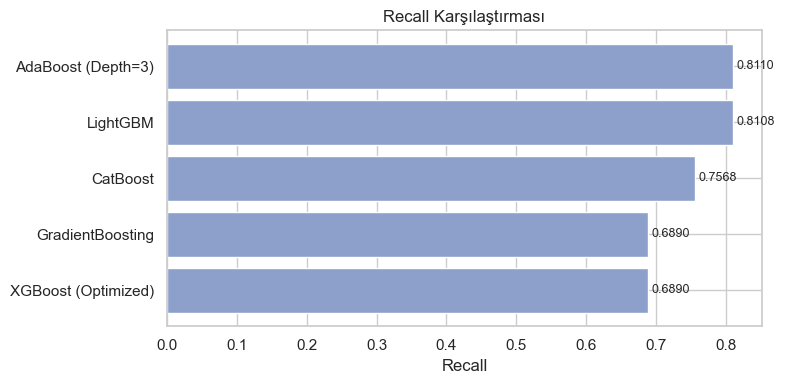

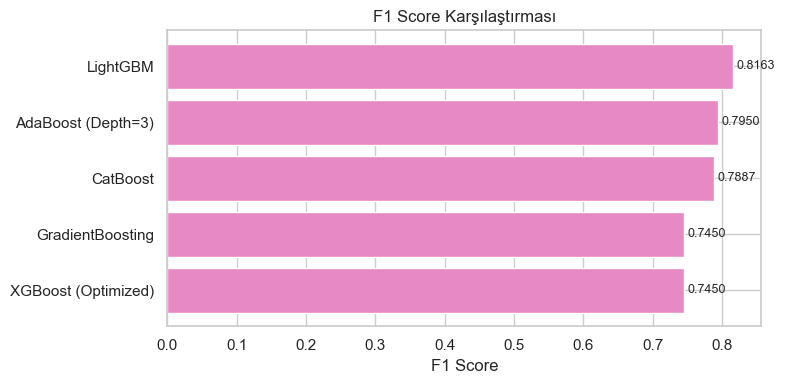

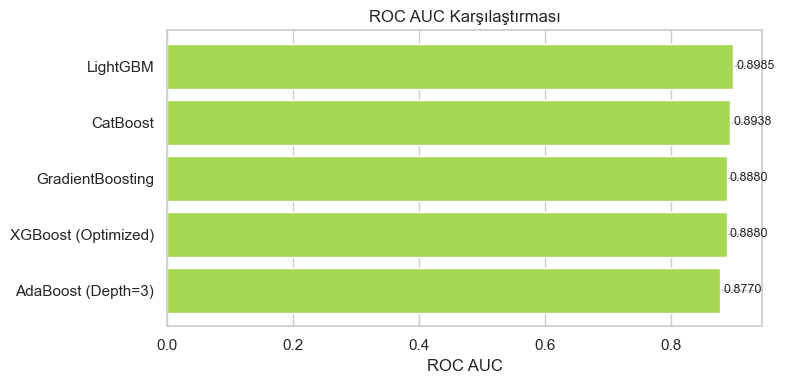

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results = {
    'Model': ['AdaBoost (Depth=3)', 'XGBoost (Optimized)', 'GradientBoosting', 'LightGBM', 'CatBoost'],
    'Accuracy': [0.827, 0.804, 0.804, 0.8492, 0.8324],
    'Precision': [0.779, 0.810, 0.810, 0.8219, 0.8235],
    'Recall': [0.811, 0.689, 0.689, 0.8108, 0.7568],
    'F1 Score': [0.795, 0.745, 0.745, 0.8163, 0.7887],
    'ROC AUC': [0.877, 0.888, 0.888, 0.8985, 0.8938]
}

df = pd.DataFrame(results)

sns.set(style="whitegrid")
colors = sns.color_palette("Set2")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 4))
    df_sorted = df.sort_values(by=metric, ascending=True)
    bars = plt.barh(df_sorted['Model'], df_sorted[metric], color=colors[i % len(colors)])
    
    # Bar uçlarına değerleri yaz
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                 f'{width:.4f}', va='center', fontsize=9)
    
    plt.title(f'{metric} Karşılaştırması')
    plt.xlabel(metric)
    plt.tight_layout()
    plt.show()



## LightGBM Selected: Proceeding with Model Optimization


In [159]:
#!pip install optuna


[I 2025-05-07 11:59:06,202] A new study created in memory with name: no-name-43011bc1-607f-4e7f-ae15-a068eeb06bed
[I 2025-05-07 11:59:06,386] Trial 0 finished with value: 0.8924066924066923 and parameters: {'n_estimators': 876, 'learning_rate': 0.15706775701436385, 'num_leaves': 66, 'max_depth': 9, 'min_child_samples': 78, 'subsample': 0.9229736991325557, 'colsample_bytree': 0.5541835425388735, 'reg_alpha': 0.5140419805424069, 'reg_lambda': 0.5144188327508531}. Best is trial 0 with value: 0.8924066924066923.
[I 2025-05-07 11:59:06,441] Trial 1 finished with value: 0.8921492921492922 and parameters: {'n_estimators': 133, 'learning_rate': 0.011377544593501557, 'num_leaves': 30, 'max_depth': 6, 'min_child_samples': 39, 'subsample': 0.8649449582624256, 'colsample_bytree': 0.5937354101904422, 'reg_alpha': 0.13455648808383824, 'reg_lambda': 0.8170880308003078}. Best is trial 0 with value: 0.8924066924066923.
[I 2025-05-07 11:59:06,503] Trial 2 finished with value: 0.8926640926640926 and para

🎯 En iyi parametreler:
{'n_estimators': 800, 'learning_rate': 0.019299745455078662, 'num_leaves': 108, 'max_depth': 10, 'min_child_samples': 32, 'subsample': 0.8120355739406183, 'colsample_bytree': 0.5609935228933652, 'reg_alpha': 0.43431531561277525, 'reg_lambda': 0.5509608346437032}

📌 Final LightGBM (Optuna)
Accuracy  : 0.8268
Precision : 0.7945
Recall    : 0.7838
F1 Score  : 0.7891
ROC AUC   : 0.9131

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       105
           1       0.79      0.78      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



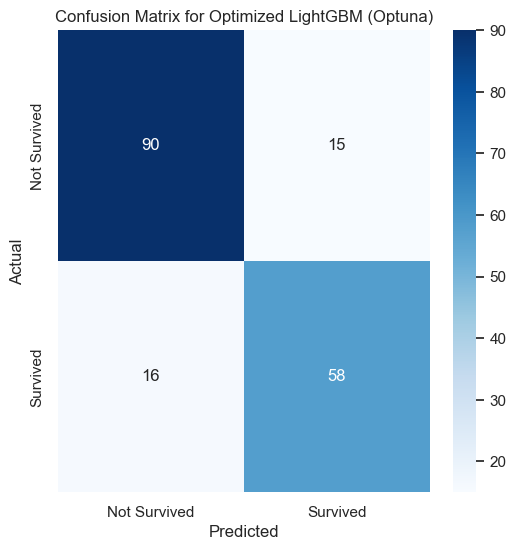

In [161]:
import lightgbm as lgb
import optuna
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_pred_proba)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)  # 50 deneme veya 10 dk

print("En iyi parametreler:")
print(study.best_params)

# Final model
best_lgb = lgb.LGBMClassifier(**study.best_params)
best_lgb.fit(X_train, y_train)
y_pred = best_lgb.predict(X_valid)
y_proba = best_lgb.predict_proba(X_valid)[:, 1]

# Metrikler
print("\nFinal LightGBM (Optuna)")
print(f"Accuracy  : {accuracy_score(y_valid, y_pred):.4f}")
print(f"Precision : {precision_score(y_valid, y_pred):.4f}")
print(f"Recall    : {recall_score(y_valid, y_pred):.4f}")
print(f"F1 Score  : {f1_score(y_valid, y_pred):.4f}")
print(f"ROC AUC   : {roc_auc_score(y_valid, y_proba):.4f}")
print("\n Classification Report:")
print(classification_report(y_valid, y_pred))

cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix for Optimized LightGBM (Optuna)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [163]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

acc_scores, prec_scores, rec_scores, f1_scores, roc_auc_scores = [], [], [], [], []

for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]
    
    model_cv = lgb.LGBMClassifier(**study.best_params)
    model_cv.fit(X_train_cv, y_train_cv)
    
    y_pred_cv = model_cv.predict(X_val_cv)
    y_proba_cv = model_cv.predict_proba(X_val_cv)[:, 1]
    
    acc_scores.append(accuracy_score(y_val_cv, y_pred_cv))
    prec_scores.append(precision_score(y_val_cv, y_pred_cv))
    rec_scores.append(recall_score(y_val_cv, y_pred_cv))
    f1_scores.append(f1_score(y_val_cv, y_pred_cv))
    roc_auc_scores.append(roc_auc_score(y_val_cv, y_proba_cv))

    print(f"Fold {fold+1}: Accuracy={acc_scores[-1]:.4f}, F1={f1_scores[-1]:.4f}, AUC={roc_auc_scores[-1]:.4f}")

print("\n 10-Fold CV Ortalama Skorlar:")
print(f"Accuracy  : {np.mean(acc_scores):.4f}")
print(f"Precision : {np.mean(prec_scores):.4f}")
print(f"Recall    : {np.mean(rec_scores):.4f}")
print(f"F1 Score  : {np.mean(f1_scores):.4f}")
print(f"ROC AUC   : {np.mean(roc_auc_scores):.4f}")


Fold 1: Accuracy=0.8444, F1=0.8000, AUC=0.9319
Fold 2: Accuracy=0.8202, F1=0.7419, AUC=0.8620
Fold 3: Accuracy=0.8427, F1=0.7879, AUC=0.8711
Fold 4: Accuracy=0.8652, F1=0.8065, AUC=0.9168
Fold 5: Accuracy=0.8315, F1=0.7619, AUC=0.8102
Fold 6: Accuracy=0.7978, F1=0.7273, AUC=0.8730
Fold 7: Accuracy=0.8315, F1=0.7887, AUC=0.8930
Fold 8: Accuracy=0.8202, F1=0.7241, AUC=0.8428
Fold 9: Accuracy=0.8427, F1=0.8000, AUC=0.9305
Fold 10: Accuracy=0.8315, F1=0.7541, AUC=0.8923

🔍 10-Fold CV Ortalama Skorlar:
Accuracy  : 0.8328
Precision : 0.8199
Recall    : 0.7310
F1 Score  : 0.7692
ROC AUC   : 0.8824


# Final model 

In [167]:
df_model.head(1)

Survived  Pclass  Sex    Age  SibSp  Parch  Fare  Embarked  Title
0         0       3    1 22.000      1      0 7.250         2      2

In [173]:
df_test.head(1)

Pclass  Sex    Age  SibSp  Parch  Fare  Embarked  Title  PassengerId
0       3    1 34.500      0      0 7.829         1      2          892

In [171]:
df_test['PassengerId'] = passenger_ids


In [181]:
X = df_model.drop("Survived", axis=1)
y = df_model["Survived"]

X_test = df_test.drop("PassengerId", axis=1)

# Alternatif olarak:
# X_test = df_test[X.columns]

final_model = lgb.LGBMClassifier(**study.best_params)
final_model.fit(X, y)

predictions = final_model.predict(X_test)


In [183]:
print(predictions[:10])  # İlk 10 tahmin


[0 0 0 0 0 0 0 0 1 0]


In [185]:
submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],  
    "Survived": predictions                 
})

submission.to_csv("submission.csv", index=False)
print("Submission dosyası oluşturuldu: submission.csv")


✅ Submission dosyası oluşturuldu: submission.csv
